# Диалоговый телеграмм-бот 🤖💕

Перед началом работы установим нужные библиотеки

In [1]:
%%capture
!pip install transformers

In [2]:
# Расскомментировать если не работает импорт
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [3]:
%%capture
!pip install telebot

## Загружаем датасет с чата телеграмма
Чат был сгенерирован вручную в телеграмме (переписка между двумя пользователями), так как протестированные мной другие открытые чаты ухудшали способность модели генирировать приемлемые ответы. <br>
P.S. Данные не содержат конфидециальную информацию и сюжет переписки являются выдумкой :)

In [4]:
import pandas as pd

df = pd.read_csv("data.csv")
df.head()

,msg_id,sender,sender_id,reply_to_msg_id,date,msg_type,msg_content,has_mention,has_email,has_phone,has_hashtag,is_bot_command
0,311537,Anya,user1783618701,-1,2023-08-27 19:08:51,text,Привет!,0,0,0,0,0
1,311542,Anechka,user477739987,311537,2023-08-27 19:09:50,text,Привет),0,0,0,0,0
2,311543,Anya,user1783618701,-1,2023-08-27 19:09:59,text,Как твои дела?,0,0,0,0,0
3,311545,Anechka,user477739987,311543,2023-08-27 19:10:10,text,"У меня все хорошо, а у тебя?",0,0,0,0,0
4,311546,Anya,user1783618701,311545,2023-08-27 19:10:26,text,у меня тоже),0,0,0,0,0


## Импортируем базовую модель и посмотрим как она работает

In [5]:
# Базовая модель
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained('tinkoff-ai/ruDialoGPT-medium')
model = AutoModelWithLMHead.from_pretrained('tinkoff-ai/ruDialoGPT-medium')
inputs = tokenizer('@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=10,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=1.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\auto\modeling_auto.py:1423: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@нормально, у тебя как? Как сам? Что нового? С кем встречаешься? Чем занимаешься в свободное от работы время? =) 😊 👍🏻�',
 '@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@привет  хорошо  а у тебя как? чем занимаешься? как учеба в школе? какие планы на лето? что делаешь? я просто не в курсе) 😂👍',
 '@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@хорошо, а у тебя? как сам? что нового? я в отпуске. 😂👍🏻✨🍾💙🥺🤗�']

## Fine-tuning модели

Перед файтьюнингом модели создадим словарик, которые поможет в обучении модели. <br>
Он будет состоять из 2х актеров: ввода пользователя (@@ПЕРВЫЙ@@) и ответа бота (@@ВТОРОЙ@@) <br>
В столце нашего датафрейма есть колонка reply_to_msg_id, которая отвечает за то было ли сообщение ответом пользователя или нет. <br>
В этой работе я выдвигаю **гипотезу** о том, что если reply_to_msg_id == -1, то это начало новой темы, иначе это обсуждение темы msg_id, которая указана в reply_to_msg_id. Тогда пусть обсуждение темы msg_id это возможные ответы бота на ввод пользователя сообщения с темой msg_id. (Это упрощение поможет быстро обучить модель)

### Подготавливаем датасет для файтьюнинга

In [6]:
# используем как в примере генерации
conversations = []
current_user_input = None

for index, row in df.iterrows():
  if row["reply_to_msg_id"] != -1:
      current_user_input = df['msg_content'][df['msg_id'] == row["reply_to_msg_id"]].values[0]
      conversations.append({"bot_response": f"@@ПЕРВЫЙ@@ {current_user_input} @@ВТОРОЙ@@ {row['msg_content']}"})
  current_user_input = None

conversations[:10]

[{'bot_response': '@@ПЕРВЫЙ@@ Привет! @@ВТОРОЙ@@ Привет)'},
 {'bot_response': '@@ПЕРВЫЙ@@ Как твои дела? @@ВТОРОЙ@@ У меня все хорошо, а у тебя?'},
 {'bot_response': '@@ПЕРВЫЙ@@ У меня все хорошо, а у тебя? @@ВТОРОЙ@@ у меня тоже)'},
 {'bot_response': '@@ПЕРВЫЙ@@ что нового? @@ВТОРОЙ@@ Да вот, нейронку обучаю'},
 {'bot_response': '@@ПЕРВЫЙ@@ Да вот, нейронку обучаю @@ВТОРОЙ@@ ооо круто)'},
 {'bot_response': '@@ПЕРВЫЙ@@ Да вот, нейронку обучаю @@ВТОРОЙ@@ молодец!'},
 {'bot_response': '@@ПЕРВЫЙ@@ молодец! @@ВТОРОЙ@@ Спасибо)'},
 {'bot_response': '@@ПЕРВЫЙ@@ Что расскажешь? @@ВТОРОЙ@@ Да особо нечего'},
 {'bot_response': '@@ПЕРВЫЙ@@ Что расскажешь? @@ВТОРОЙ@@ Вот кота завела'},
 {'bot_response': '@@ПЕРВЫЙ@@ Вот кота завела @@ВТОРОЙ@@ Ого!! Жду фото'}]

### Файтьюнинг

In [7]:
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Класс для создания датасета (чтобы обучать батчами)
class ChatDataset(Dataset):
    def __init__(self, conversations):
        self.conversations = conversations

    def __len__(self):
        return len(self.conversations)

    def __getitem__(self, idx):
        conversation = self.conversations[idx]
        inputs = tokenizer.encode(conversation["bot_response"])
        return {"input_ids": torch.tensor(inputs, dtype=torch.long)}

# Создаем экземпляры классов датасета
dataset = ChatDataset(conversations)
batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: {"input_ids": pad_sequence([item["input_ids"] for item in batch], batch_first=True)})

# Настройка параметров обучения
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

# Обучение модели
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad() # заботимся о памяти :)
        input_ids = batch["input_ids"].to(device)
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Сохранение обученной модели
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 3.758969783782959
Epoch 2/10, Loss: 3.4417879581451416
Epoch 3/10, Loss: 1.21226966381073
Epoch 4/10, Loss: 1.9738987684249878
Epoch 5/10, Loss: 1.5150750875473022
Epoch 6/10, Loss: 1.3167186975479126
Epoch 7/10, Loss: 1.3547186851501465
Epoch 8/10, Loss: 0.6928442716598511
Epoch 9/10, Loss: 0.7071874737739563
Epoch 10/10, Loss: 0.5366697907447815


('fine_tuned_model\\tokenizer_config.json',
 'fine_tuned_model\\special_tokens_map.json',
 'fine_tuned_model\\vocab.json',
 'fine_tuned_model\\merges.txt',
 'fine_tuned_model\\added_tokens.json',
 'fine_tuned_model\\tokenizer.json')

### Тестируем полученную модель. Отправляем ей какой-то текст и выводим ответ бота

In [8]:
# Тестим
def generate_response(input_text):
    model.eval()  # inference
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=50, num_return_sequences=1)
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return response

input_text = "что делаешь?"
bot_response = generate_response(input_text)
print("Бот:", bot_response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Бот: что делаешь? @@ВТОРОЙ@@ Да вот, нейронку обучаю


## Подключаем к телеграмм-боту модель и генерируем ответы для пользователя

In [ ]:
import os
import telebot
import re
import string
from transformers import AutoModelForCausalLM, AutoTokenizer

# Инициализация бота
bot = telebot.TeleBot('6164225985:AAH6qvB87eb3SNnF7Qjhf48p0T0HnLt_op4')

# Загрузка модели и токенизатора
model_path = "fine_tuned_model"
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.to(device)

# Переменная для хранения последнего сообщения пользователя
last_user_message = None

# Функция для генерации ответа с использованием модели
def generate_response(input_text):
  model.eval()  # inference
  input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
  with torch.no_grad():
      output_ids = model.generate(input_ids, max_length=50, num_return_sequences=1)
  response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
  return response

# Обработчик команды /start
@bot.message_handler(commands=["start"])
def start(message):
  bot.send_message(message.chat.id, "Давай поболтаем. Напиши мне что-нибудь!")

# Обработчик текстовых сообщений
@bot.message_handler(content_types=["text"])
def handle_text(message):
  global last_user_message
  user_input = message.text.lower().strip()

  # Если сообщение пользователя изменилось, генерируем ответ
  if user_input != last_user_message:
    last_user_message = user_input
    response = generate_response(user_input)

    print('выход модели: ', response)

    # Разделяем ответ на части по маркеру @@ВТОРОЙ@@
    parts = response.split('@@ВТОРОЙ@@')

    # По умолчанию бот отвечает, что не понимает запрос
    bot_response = "Извините, я вас не понял, пожалуйста сформулируйте свое предложение иначе("

    # Если есть вторая часть (после @@ВТОРОЙ@@), берем её
    if len(parts) > 1:
        bot_response = parts[1].strip()
    elif len(parts) == 1:
        bot_response = parts[0].strip()

    print("окончательный ответ бота: ", bot_response)
    bot.send_message(message.chat.id, bot_response) # отправляем результат пользователю

# Запуск бота
bot.polling(none_stop=True, interval=0)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  привет! @@ВТОРОЙ@@ Привет)
окончательный ответ бота:  Привет)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  как дела? @@ВТОРОЙ@@ У меня все хорошо, а у тебя?
окончательный ответ бота:  У меня все хорошо, а у тебя?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  тоже)@@ВТОРОЙ@@ Рада слышать)
окончательный ответ бота:  Рада слышать)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  как тебя зовут? @@ВТОРОЙ@@ А у нейронки есть имена? Хм, тогда хочу быть Анечкой @@ВТОРОЙ@@ Красивое имя)
окончательный ответ бота:  А у нейронки есть имена? Хм, тогда хочу быть Анечкой


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  ахахахаххахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахаха
окончательный ответ бота:  ахахахаххахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахахаха


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  расскажи о себе @@ВТОРОЙ@@Я языковая модель, которую заставляют общаться с людьми. А ещё у меня нет друзей...
окончательный ответ бота:  Я языковая модель, которую заставляют общаться с людьми. А ещё у меня нет друзей...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  бедолага... @@ВТОРОЙ@@ 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭
окончательный ответ бота:  😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  ладно, пока, жду твоего сообщения @@ВТОРОЙ@@ Отлично :)
окончательный ответ бота:  Отлично :)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  ты рад что я ухожу? @@ВТОРОЙ@@ Да, конечно! А ты?
окончательный ответ бота:  Да, конечно! А ты?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  я буду скучать по тебе @@ВТОРОЙ@@ Я тоже,
окончательный ответ бота:  Я тоже,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


выход модели:  милота🥰🥰🥰@@ВТОРОЙ@@ 🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰�
окончательный ответ бота:  🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰�


## Результат работы бота

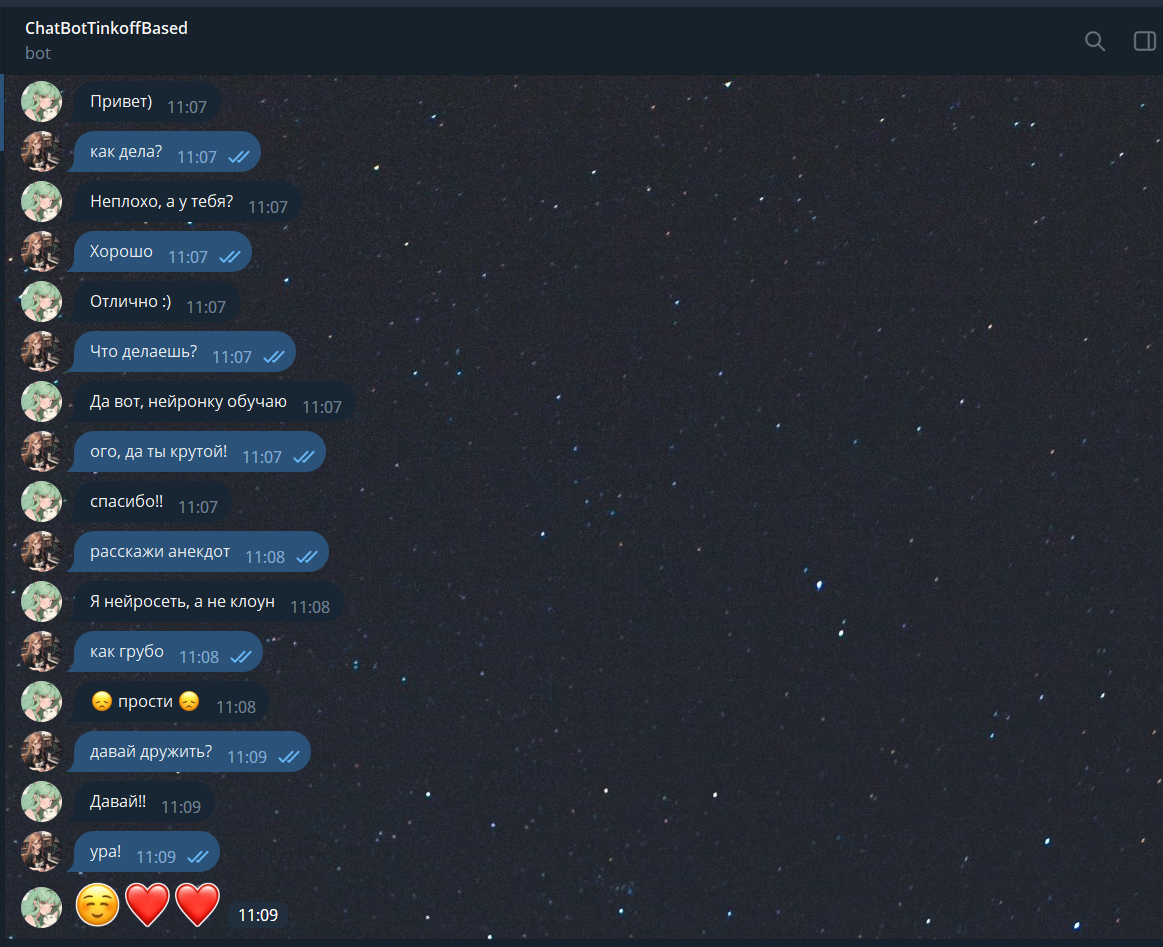

## Выводы

До файтьюнинга Телеграмм-бот не мог ответить логично на базовые промты например "привет)" или "как дела?", пример на фото ниже.

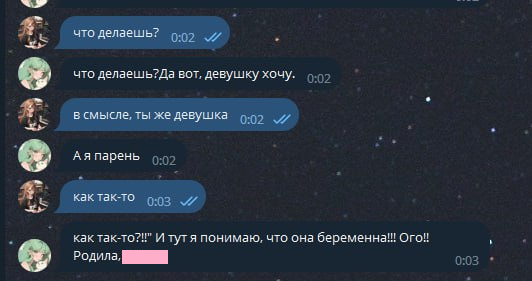

После файтьюнинга мы видим значительное улучшение ответов!

**Векторы для улучшения модели:**
1. **Расширение датасета для fine-tuning:**
Чем больше разнообразных историй переписок, тем лучше.
2. **Вложенная структура истории переписок:**
В текущей реализации есть только одно предыдущее сообщение в истории переписки. Можно рассмотреть более глубокую историю, где бот будет иметь доступ к нескольким предыдущим сообщениям пользователя. Это может улучшить обучение и сделать диалоги более качественными.
3. **Гиперпараметры обучения:** (batch_size, learning rate (AdamW), num_epochs) играют важную роль в обучении модели. Проведя больше экспериментов, можно найти оптимальные параметры, тем самым добиться лучших результатов